In [5]:
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1. Caricamento e Preprocessing
# -------------------------------

# Parametri di connessione
host = "localhost"
port = "5432"
dbname = "DataScience"
user = "postgres"
password = "2430"

# Connessione a PostgreSQL
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

# Query sulla vista
query = "SELECT * FROM public.vew_mts_provsensori"

# Caricare i dati in un DataFrame di Pandas
df = pd.read_sql_query(query, conn)

# Chiudere la connessione
conn.close()

print("Primi dati caricati:")
print(df.head())

# Conversione della colonna 'giorno' in formato datetime
df['giorno'] = pd.to_datetime(df['giorno'])

# Aggiungere features: giorno della settimana e mese
df['giorno_della_settimana'] = df['giorno'].dt.weekday
df['mese'] = df['giorno'].dt.month

# Creare il target: traffico totale per il giorno
df['target'] = df['total_transiti']

# Creare variabili per i giorni precedenti
df['prev_transiti'] = df['total_transiti'].shift(1)
df['prev_trleggeri'] = df['total_trleggeri'].shift(1)
df['prev_trpesanti'] = df['total_trpesanti'].shift(1)
df['prev_trnonclassificati'] = df['total_trnonclassificati'].shift(1)

# Rimuovere le righe con NaN (es. la prima riga, dovuta allo shift)
df = df.dropna()

# Salva il tipo di sensore originale per operazioni successive
df['sensor_type'] = df['sensori']

# Applicare One-Hot Encoding alla colonna "sensori"
# I possibili valori sono "Aboveground" e "Underground"
df = pd.get_dummies(df, columns=["sensori"], prefix="sensori")

# Creare una nuova feature: rolling average dei transiti (per ridurre il rumore), calcolata su una finestra di 3 giorni,
# raggruppando per tipo di sensore ('sensor_type')
df['rolling_prev_transiti'] = df.groupby('sensor_type')['total_transiti'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Ordina per giorno
df = df.sort_values('giorno')

Primi dati caricati:
  provincia      giorno  total_transiti  total_trleggeri  total_trpesanti  \
0        MO  2019-01-01          143577           142750              822   
1        BO  2019-01-01          261563           260314             1242   
2        RN  2019-01-01            8264             8228               36   
3        PR  2019-01-01            4602             4588               14   
4        PC  2019-01-01            7138             7093               45   

   total_trnonclassificati  total_trdiurno  total_trnotturno  total_trferiali  \
0                       50           86068             57509                0   
1                       70          158381            103182                0   
2                        0            5210              3054                0   
3                        0            2712              1890                0   
4                        0            4286              2852                0   

   total_trfestivi  ngiornose

C:\Users\matte\AppData\Local\Temp\ipykernel_85180\96725209.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)



MAE per il modello misto (entrambi i sensori, con rolling e scaling): 49176.976450040616

Importanza delle feature nel modello misto:
                  Feature  Importance
6   rolling_prev_transiti    0.789262
2          prev_trpesanti    0.057111
1          prev_trleggeri    0.050074
0           prev_transiti    0.042250
5                    mese    0.025136
3  prev_trnonclassificati    0.019573
4  giorno_della_settimana    0.016591
8     sensori_Underground    0.000002
7     sensori_Aboveground    0.000001


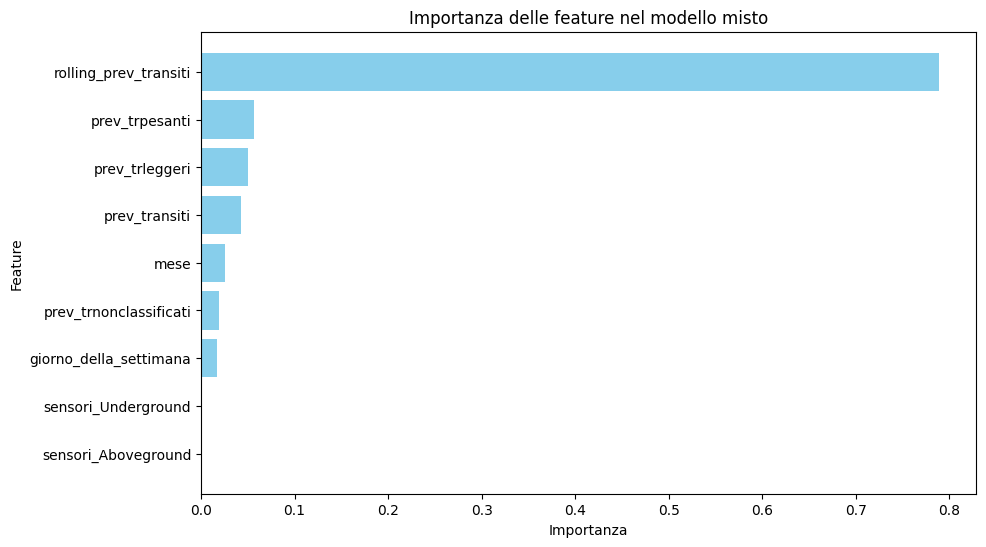

In [6]:
# -------------------------------
# 2. Modellazione Mista con Scaling
# -------------------------------

# Definiamo le feature di base
base_feature_cols = [
    'prev_transiti', 'prev_trleggeri', 'prev_trpesanti', 'prev_trnonclassificati',
    'giorno_della_settimana', 'mese', 'rolling_prev_transiti'
]

# Includiamo le feature relative ai sensori (ottenute dall'encoding)
sensor_feature_cols = [col for col in df.columns if col.startswith('sensori_')]
mixed_feature_cols = base_feature_cols + sensor_feature_cols

# Costruiamo il set di feature (X) e il target (y) per il modello misto
X_mixed = df[mixed_feature_cols]
y_mixed = df['target']

# Dividere il dataset in training e test (80% training, 20% test)
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(
    X_mixed, y_mixed, test_size=0.2, shuffle=False
)

# Standardizziamo le feature per rendere le scale comparabili
scaler = StandardScaler()
X_train_mixed_scaled = scaler.fit_transform(X_train_mixed)
X_test_mixed_scaled = scaler.transform(X_test_mixed)

# Creare il modello misto (Random Forest)
model_mixed = RandomForestRegressor(n_estimators=100, random_state=42)
model_mixed.fit(X_train_mixed_scaled, y_train_mixed)
y_pred_mixed = model_mixed.predict(X_test_mixed_scaled)
mae_mixed = mean_absolute_error(y_test_mixed, y_pred_mixed)
print(f"\nMAE per il modello misto (entrambi i sensori, con rolling e scaling): {mae_mixed}")

# Analisi dell'importanza delle feature nel modello misto
importances = model_mixed.feature_importances_
importance_df = pd.DataFrame({'Feature': mixed_feature_cols, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nImportanza delle feature nel modello misto:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.title("Importanza delle feature nel modello misto")
plt.gca().invert_yaxis()
plt.show()
